In [88]:
import re
import glob
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.io import netcdf
from rasterio.plot import show
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from matplotlib.tri import Triangulation, LinearTriInterpolator

### Гео-данные станций

In [2]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
posts_df = pd.read_csv('../data/Датасет_04/02_координаты_станций.csv', sep=';', names=['post_name', 'latitude', 'longitude'])
posts = gpd.GeoDataFrame(
                posts_df, geometry=gpd.points_from_xy(posts_df.longitude, posts_df.latitude))

In [4]:
posts

,post_name,latitude,longitude,geometry
0,Академика,55.658163,37.471434,POINT (37.47143 55.65816)
1,Бутлерова,55.649412,37.535874,POINT (37.53587 55.64941)
2,Глебовская,55.811801,37.712490,POINT (37.71249 55.81180)
3,Коптевский,55.833222,37.525158,POINT (37.52516 55.83322)
4,Марьино,55.652695,37.751502,POINT (37.75150 55.65269)
5,Останкино,55.821154,37.612592,POINT (37.61259 55.82115)
6,Пролетарский,55.635129,37.658684,POINT (37.65868 55.63513)
7,Спиридоновка,55.759354,37.595584,POINT (37.59558 55.75935)
8,Туристская,55.856324,37.426628,POINT (37.42663 55.85632)
9,Шаболовка,55.715698,37.605238,POINT (37.60524 55.71570)


In [5]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [6]:
ao = gpd.read_file('../data/geo/ao.geojson')
mo = gpd.read_file('../data/geo/mo.geojson')

In [7]:
ao.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
mo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

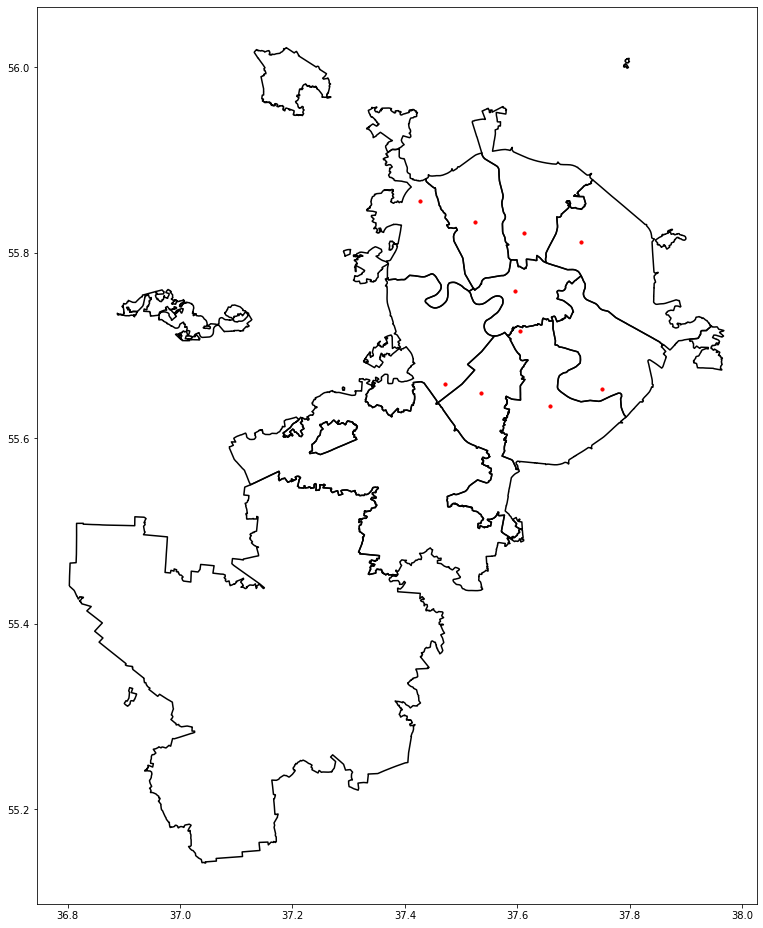

In [9]:
fig, ax = plt.subplots()

ao.boundary.plot(ax=ax, color='black', edgecolor='black')
#mo.boundary.plot(ax=ax, color='black', edgecolor='grey')
posts.plot(ax=ax, marker='o', color='red', markersize=10, aspect=1.65)
set_size(10,20)

plt.show()

### Измерения показаталей

In [10]:
datasets = {}
files = glob.glob('../data/Датасет_04/01_данные станций/[А-Я]*.xlsx')

for file in tqdm(files):
    name = re.findall(r'\w+', file)[4]
    data = pd.read_excel(file)
    data['Дата и время'] = pd.to_datetime(data['Дата и время'])
    data = data.sort_values(by='Дата и время')[:-2]
    datasets[name] = data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.44s/it]


In [11]:
def plot_report(data):
    fig, axs = plt.subplots(5)

    axs[0].plot(data['Дата и время'], data['CO'])

    axs[1].plot(data['Дата и время'], data['NO2'])
    axs[1].plot(data['Дата и время'], data['NO'])
    axs[1].plot(data['Дата и время'], data['PM10'])

    axs[2].plot(data['Дата и время'], data['Осадки'])
    axs[2].plot(data['Дата и время'], data['-T-'])
    axs[2].plot(data['Дата и время'], data['| V |'])

    axs[3].plot(data['Дата и время'], data['Давление'])

    axs[4].plot(data['Дата и время'], data['Влажность'])



    axs[0].legend(['CO'])
    axs[1].legend(['NO2', 'NO', 'PM10'])
    axs[2].legend(['Осадки', '-T-', '| V |'])
    axs[3].legend(['Давление'])
    axs[4].legend(['Влажность'])

    set_size(25,15)

In [12]:
datasets.keys()

dict_keys(['Коптевский', 'Глебовская', 'Останкино', 'Академика', 'Спиридоновка', 'Шаболовка', 'Туристская', 'Бутлерова', 'Пролетарский', 'Марьино'])

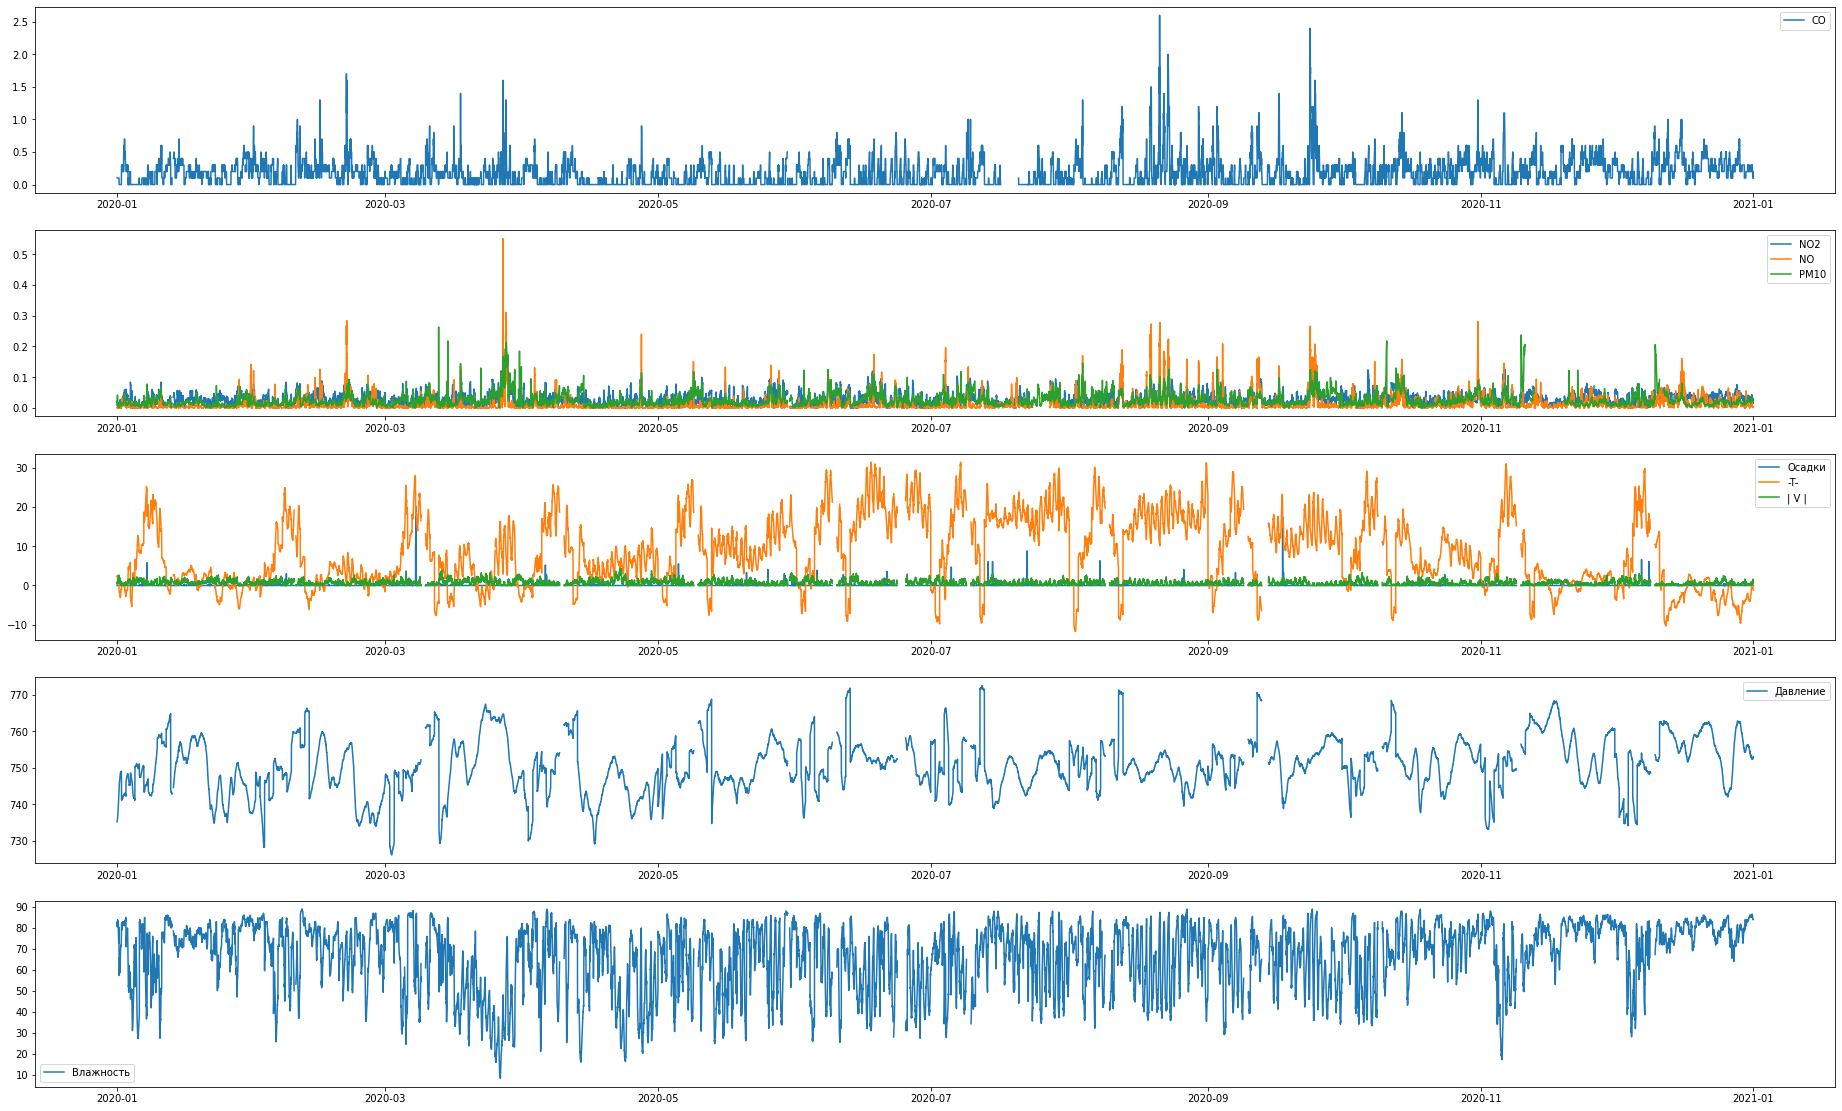

In [13]:
plot_report(datasets['Марьино'])

In [14]:
mask = (data['Дата и время'] >= '2020-09-23 19:00:00') & (data['Дата и время'] < '2020-09-24 00:00:00')

In [15]:
tmp_slice = pd.DataFrame(columns=['Дата и время', 'CO', 'NO2', 'NO', 'PM10', 'PM25', 'Unnamed: 6', '-T-',
       '| V |', '_V_', 'Давление', 'Влажность', 'Осадки', 'latitude',
       'longitude', 'post_name'])

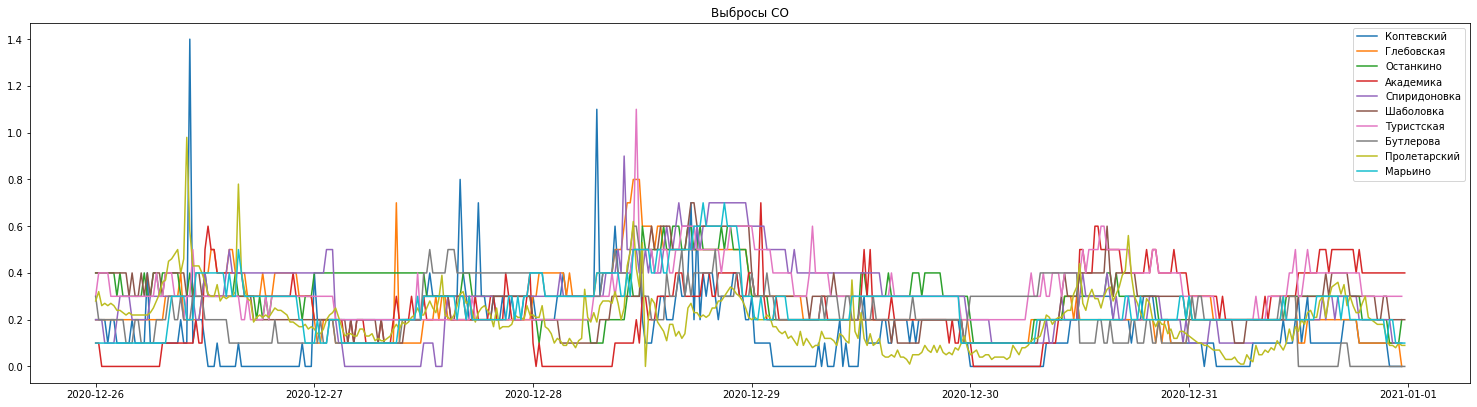

In [16]:
fig, axs = plt.subplots(1)

# keys = ['Бутлерова', 'Пролетарскии', 'Марьино', 'Туристская', 'Глебовская']
keys = datasets.keys()
for key in keys:
    mask = (datasets[key]['Дата и время'] >= '2020-12-26 00:00:00') & (datasets[key]['Дата и время'] < '2021-01-01 00:00:00')
    axs.plot(datasets[key][mask==True]['Дата и время'], datasets[key][mask==True]['CO'])
    
    tmp = datasets[key][mask==True].copy()

    tmp2 = posts_df.query('post_name == @key')

    tmp['latitude'] = tmp2['latitude'].values[0]
    tmp['longitude'] = tmp2['longitude'].values[0]
    tmp['post_name'] = tmp2['post_name'].values[0]
    
    tmp_slice = pd.concat([tmp_slice, tmp])

axs.legend(keys)
axs.set_title('Выбросы CO')
set_size(20,5)

In [17]:
exmpl_data = tmp_slice[['Дата и время', 'CO', 'latitude', 'longitude', 'post_name']].rename(columns={'Дата и время': 'datetime'}).reset_index(drop=True)
exmpl_data['datetime'] = exmpl_data['datetime'].dt.round('1h')
exmpl_data = exmpl_data.groupby(by=['datetime', 'latitude', 'longitude', 'post_name']).mean().reset_index()

posts_data = gpd.GeoDataFrame(exmpl_data[['datetime', 'CO']], geometry=gpd.points_from_xy(exmpl_data.longitude, exmpl_data.latitude))

In [18]:
exmpl_data.head()

,datetime,latitude,longitude,post_name,CO
0,2020-12-26,55.635129,37.658684,Пролетарский,0.30
1,2020-12-26,55.649412,37.535874,Бутлерова,0.25
2,2020-12-26,55.652695,37.751502,Марьино,0.10
3,2020-12-26,55.658163,37.471434,Академика,0.10
4,2020-12-26,55.715698,37.605238,Шаболовка,0.40


In [19]:
posts_data.head()

,datetime,CO,geometry
0,2020-12-26,0.30,POINT (37.65868 55.63513)
1,2020-12-26,0.25,POINT (37.53587 55.64941)
2,2020-12-26,0.10,POINT (37.75150 55.65269)
3,2020-12-26,0.10,POINT (37.47143 55.65816)
4,2020-12-26,0.40,POINT (37.60524 55.71570)


## Подготовка данных с Copernicus 

In [20]:
file2read = netcdf.NetCDFFile('../data/copernicus/CO_2020_12_26_2021_01_10.nc','r')

In [21]:
file2read.variables

{'longitude': <scipy.io.netcdf.netcdf_variable at 0x7fd210b964e0>,
 'latitude': <scipy.io.netcdf.netcdf_variable at 0x7fd210b96160>,
 'level': <scipy.io.netcdf.netcdf_variable at 0x7fd1e1f154a8>,
 'time': <scipy.io.netcdf.netcdf_variable at 0x7fd201822470>,
 'co_conc': <scipy.io.netcdf.netcdf_variable at 0x7fd2018220b8>}

In [22]:
points_data = gpd.GeoDataFrame(columns=['datetime', 'CO', 'geometry'])
time_len = len(file2read.variables['time'].data)
base = datetime(2020, 12, 26, 0, 0)
date_list = [base + timedelta(hours=x) for x in range(time_len)]

In [23]:
file2read.variables['longitude'].data

array([37.45, 37.55, 37.65, 37.75, 37.85], dtype=float32)

In [24]:
file2read.variables['latitude'].data

array([55.85, 55.75, 55.65], dtype=float32)

In [25]:
date_list[-1]

datetime.datetime(2021, 1, 10, 23, 0)

In [26]:
for i, lat in enumerate(file2read.variables['latitude'].data):
    for j, lon in enumerate(file2read.variables['longitude'].data):
        point_data = file2read.variables['co_conc'].data[::,0,i,j]
        # data[::,0,<latitude>,<longitude>]
        df = pd.DataFrame({'datetime': date_list, 'CO': point_data})
        
        tmp = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lon*np.ones(time_len), lat*np.ones(time_len)))
        
        points_data = pd.concat([points_data, tmp]).reset_index(drop=True)

In [27]:
t_point = gpd.points_from_xy([37.65], [55.65])
mask = []
for i in range(len(points_data)):
    mask.append(points_data['geometry'][i] == t_point)

In [28]:
x = file2read.variables['co_conc'].data[::,0,2,2]

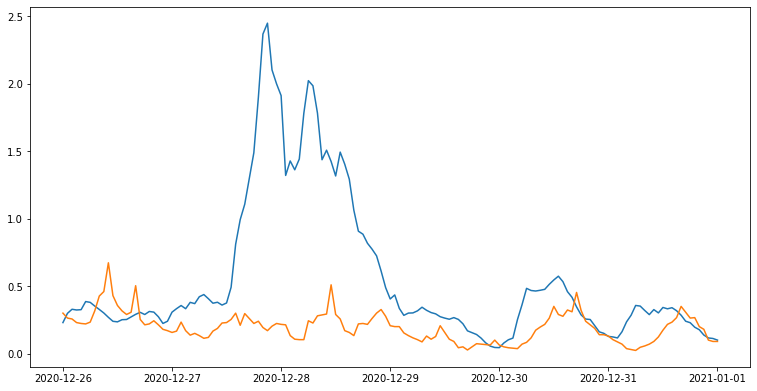

In [29]:
time = exmpl_data.query('post_name == "Пролетарский"').datetime
plt.plot(time, (x[:145] / 300)-0.65)
plt.plot(time, exmpl_data.query('post_name == "Пролетарский"')['CO'].values)
set_size(10,5)

In [30]:
points_data['CO'] = (points_data['CO'] / 300)-0.65

### Данные с Copernicus и с датчиков

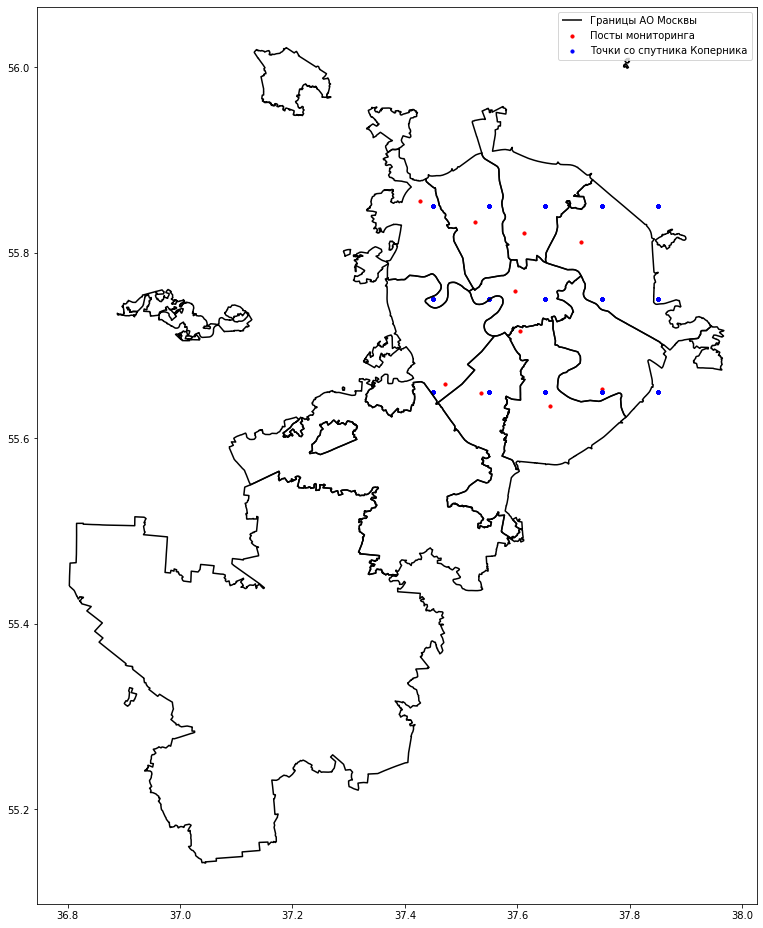

In [32]:
fig, ax = plt.subplots()

ao.boundary.plot(ax=ax, color='black', edgecolor='black')
#mo.boundary.plot(ax=ax, color='black', edgecolor='grey')
posts.plot(ax=ax, marker='o', color='red', markersize=10, aspect=1.65)
points_data.plot(ax=ax, marker='o', color='blue', markersize=10, aspect=1.65)

ax.legend(['Границы АО Москвы', 'Посты мониторинга', 'Точки со спутника Коперника'])
set_size(10,20)
plt.show()

In [33]:
points3d = points_data # pd.concat([posts_data, points_data]).reset_index(drop=True)

In [34]:
mask = (points3d['datetime'] >= '2020-12-31 23:00:00') & (points3d['datetime'] < '2021-01-01 00:00:00')

In [35]:
points3dslice = points3d[mask==True].reset_index(drop=True)

In [36]:
totalPointsArray = np.zeros([points3dslice.shape[0],3])
#iteration over the geopandas dataframe
for index, point in points3dslice.iterrows():
    pointArray = np.array([point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0],point['CO']])
    totalPointsArray[index] = pointArray
totalPointsArray[:,:]

array([[3.74500008e+01, 5.58499985e+01, 2.46993721e-01],
       [3.75499992e+01, 5.58499985e+01, 2.70219982e-01],
       [3.76500015e+01, 5.58499985e+01, 2.06718266e-01],
       [3.77500000e+01, 5.58499985e+01, 9.74659324e-02],
       [3.78499985e+01, 5.58499985e+01, 5.20094037e-02],
       [3.74500008e+01, 5.57500000e+01, 1.89925969e-01],
       [3.75499992e+01, 5.57500000e+01, 2.19527721e-01],
       [3.76500015e+01, 5.57500000e+01, 1.73338294e-01],
       [3.77500000e+01, 5.57500000e+01, 9.54552293e-02],
       [3.78499985e+01, 5.57500000e+01, 6.71585798e-02],
       [3.74500008e+01, 5.56500015e+01, 8.70923996e-02],
       [3.75499992e+01, 5.56500015e+01, 1.05330825e-01],
       [3.76500015e+01, 5.56500015e+01, 1.12017870e-01],
       [3.77500000e+01, 5.56500015e+01, 5.52631617e-02],
       [3.78499985e+01, 5.56500015e+01, 1.85438395e-02]])

In [37]:
triFn = Triangulation(totalPointsArray[:,0],totalPointsArray[:,1])
linTriFn = LinearTriInterpolator(triFn,totalPointsArray[:,2])

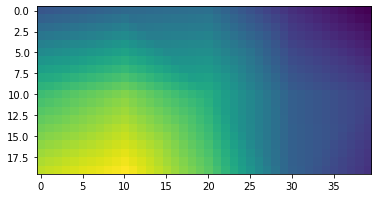

In [38]:
rasterRes = 0.01

xCoords = np.arange(totalPointsArray[:,0].min(), totalPointsArray[:,0].max(), rasterRes)
yCoords = np.arange(totalPointsArray[:,1].min(), totalPointsArray[:,1].max(), rasterRes)
zCoords = np.zeros([yCoords.shape[0],xCoords.shape[0]])

for indexX, x in np.ndenumerate(xCoords):
    for indexY, y in np.ndenumerate(yCoords):
        x = np.round(x, 6)
        y = np.round(y, 6)
        
        tempZ = linTriFn(x,y)
        if tempZ == tempZ:
            zCoords[indexY,indexX]=tempZ
        else:
            zCoords[indexY,indexX]=np.nan

plt.imshow(zCoords)

In [39]:
import rasterio
from rasterio.transform import Affine
transform = Affine.translation(xCoords[0] - rasterRes/2, yCoords[0] - rasterRes/2) * Affine.scale(rasterRes, rasterRes)
transform
Affine(2.0, 0.0, 623621.3579761666,
       0.0, 2.0, 8359156.448053772)
#get crs as wkt
from rasterio.crs import CRS
rasterCrs = CRS.from_epsg(32718)
rasterCrs.data
{'init': 'epsg:32718'}
#definition, register and close of interpolated raster
triInterpRaster = rasterio.open('./rst/triangleInterpolation_cop.tif',
                                'w',
                                driver='GTiff',
                                height=zCoords.shape[0],
                                width=zCoords.shape[1],
                                count=1,
                                dtype=zCoords.dtype,
                                #crs='+proj=latlong',
                                crs={'init': 'epsg:32718'},
                                transform=transform,
                                )
triInterpRaster.write(zCoords,1)
triInterpRaster.close()

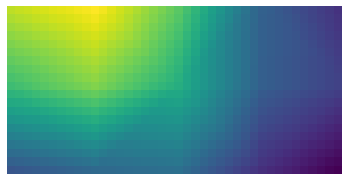

In [40]:
fig = plt.figure()
ax = plt.subplot()
ax.imshow(np.flipud(zCoords))
ax.set_axis_off()
ax.set_alpha(0.5)
fig.savefig('CO_31dec23h.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0, transparent=True)

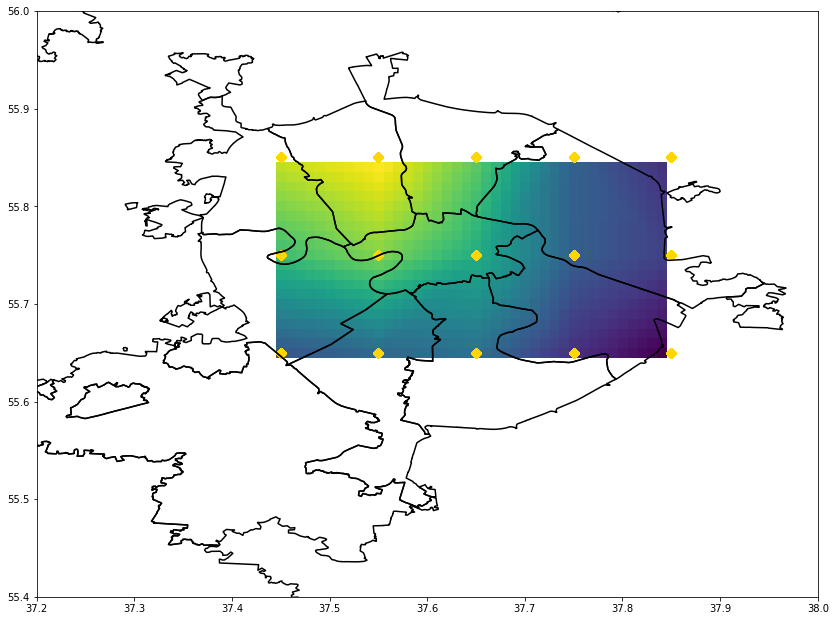

In [41]:

fig, ax = plt.subplots(figsize=(14,26))
ax.set_xlim(37.2,38.0)
ax.set_ylim(55.4,56.0)

src = rasterio.open("./rst/triangleInterpolation_cop.tif")
ao.boundary.plot(ax=ax, color='black', edgecolor='black', aspect=2.25)

points3d.plot(ax=ax, marker='D',markersize=50, color='gold', aspect=2.25)

show(src)
plt.show()

### Подготовка датасета для АЕ-нейросети

In [53]:
start = datetime(2020, 12, 26, 0, 0)
step = timedelta(hours=1)

t_cols = ['Дата и время', 'CO', 'post_name', '-T-', '| V |', '_V_', 'Давление', 'Влажность']
n_cols = ['CO', '-T-', '| V |', '_V_', 'Давление', 'Влажность']

In [54]:
len(tmp_slice['Дата и время'].dt.round('1h').unique()), min(tmp_slice['Дата и время'].dt.round('1h').unique())

(145, numpy.datetime64('2020-12-26T00:00:00.000000000'))

In [55]:
time_len = len(tmp_slice['Дата и время'].dt.round('1h').unique()) #len(file2read.variables['time'].data)
date_list = [start + timedelta(hours=x) for x in range(time_len)]
date_list[:5]

[datetime.datetime(2020, 12, 26, 0, 0),
 datetime.datetime(2020, 12, 26, 1, 0),
 datetime.datetime(2020, 12, 26, 2, 0),
 datetime.datetime(2020, 12, 26, 3, 0),
 datetime.datetime(2020, 12, 26, 4, 0)]

### Входные значения - данные со станций

In [56]:
scaler = StandardScaler()

In [57]:
inputs = tmp_slice[t_cols].rename(columns={'Дата и время': 'datetime'}).reset_index(drop=True)

inputs['datetime'] = inputs['datetime'].dt.round('1h')
inputs = inputs.groupby(by=['datetime', 'post_name']).mean().reset_index()
inputs[n_cols] = scaler.fit_transform(inputs[n_cols])
inputs = inputs.fillna(0)

In [58]:
# scaler.inverse_transform(inputs[n_cols])

In [59]:
inputs_np = np.zeros((time_len-1,60))

for i in tqdm(range(1, time_len)):
    hour_start = date_list[i-1]
    hour_end = date_list[i]
    
    mask = (inputs['datetime'] >= hour_start) & (inputs['datetime'] < hour_end)
    tmp = inputs[mask==True].sort_values(by='post_name')[n_cols].values.flatten()
    inputs_np[i-1] = tmp

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 573.26it/s]


(<matplotlib.image.AxesImage at 0x7fd1e1ef7518>, (144, 60))

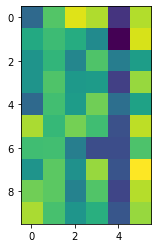

In [60]:
plt.imshow(inputs_np[0].reshape(10, 6)), inputs_np.shape #cmap='gist_gray'

In [61]:
with open('./tmp/inputs_dec.npy', 'wb') as f:
    np.save(f, inputs_np)

### Целевые значения - данные с коперника

In [62]:
points_data.head()

,datetime,CO,geometry
0,2020-12-26 00:00:00,0.279855,POINT (37.45000 55.85000)
1,2020-12-26 01:00:00,0.327263,POINT (37.45000 55.85000)
2,2020-12-26 02:00:00,0.297571,POINT (37.45000 55.85000)
3,2020-12-26 03:00:00,0.299438,POINT (37.45000 55.85000)
4,2020-12-26 04:00:00,0.227980,POINT (37.45000 55.85000)


In [63]:
targets_np = np.zeros((time_len-1, 800))
rasterRes = 0.01

for i in tqdm(range(1, time_len)):
    hour_start = date_list[i-1]
    hour_end = date_list[i]
    
    mask = (points_data['datetime'] >= hour_start) & (points_data['datetime'] < hour_end)
    
    time_slice = points3d[mask==True].reset_index(drop=True)
    
    totalPointsArray = np.zeros([time_slice.shape[0],3])
   
    for index, point in time_slice.iterrows():
        pointArray = np.array([point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0],point['CO']])
        totalPointsArray[index] = pointArray
    
    triFn = Triangulation(totalPointsArray[:,0],totalPointsArray[:,1])
    linTriFn = LinearTriInterpolator(triFn,totalPointsArray[:,2])
    
    xCoords = np.arange(totalPointsArray[:,0].min(), totalPointsArray[:,0].max(), rasterRes)
    yCoords = np.arange(totalPointsArray[:,1].min(), totalPointsArray[:,1].max(), rasterRes)
    zCoords = np.zeros([yCoords.shape[0],xCoords.shape[0]])

    #loop among each cell in the raster extension
    for indexX, x in np.ndenumerate(xCoords):
        for indexY, y in np.ndenumerate(yCoords):
            x = np.round(x, 6)
            y = np.round(y, 6)

            tempZ = linTriFn(x,y)
            #filtering masked values
            if tempZ == tempZ:
                zCoords[indexY,indexX]=tempZ
            else:
                zCoords[indexY,indexX]=0
        
    targets_np[i-1] = zCoords.flatten()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:09<00:00, 14.50it/s]


(<matplotlib.image.AxesImage at 0x7fd1f1023d68>, (144, 60))

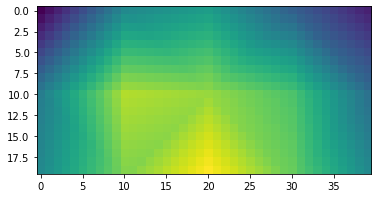

In [87]:
plt.imshow(targets_np[3].reshape(20, 40)), inputs_np.shape

In [68]:
with open('./tmp/targets_dec.npy', 'wb') as f:
    np.save(f, targets_np)

In [76]:
targets_np.shape

(144, 800)

In [83]:
geodata = np.flipud(targets_np[0].reshape(20, 40))
geodata.shape

(20, 40)

In [90]:
geodata[2][4]
# geodata[долгота][широта]

0.28455767446558866

In [84]:
xCoords, len(xCoords)

(array([37.45000076, 37.46000076, 37.47000076, 37.48000076, 37.49000076,
        37.50000076, 37.51000076, 37.52000076, 37.53000076, 37.54000076,
        37.55000076, 37.56000076, 37.57000076, 37.58000076, 37.59000076,
        37.60000076, 37.61000076, 37.62000076, 37.63000076, 37.64000076,
        37.65000076, 37.66000076, 37.67000076, 37.68000076, 37.69000076,
        37.70000076, 37.71000076, 37.72000076, 37.73000076, 37.74000076,
        37.75000076, 37.76000076, 37.77000076, 37.78000076, 37.79000076,
        37.80000076, 37.81000076, 37.82000076, 37.83000076, 37.84000076]),
 40)

In [91]:
with open('./tmp/x_coords.npy', 'wb') as f:
    np.save(f, xCoords)

In [92]:
with open('./tmp/y_coords.npy', 'wb') as f:
    np.save(f, yCoords)

In [85]:
yCoords, len(yCoords)

(array([55.65000153, 55.66000153, 55.67000153, 55.68000153, 55.69000153,
        55.70000153, 55.71000153, 55.72000153, 55.73000153, 55.74000153,
        55.75000153, 55.76000153, 55.77000153, 55.78000153, 55.79000153,
        55.80000153, 55.81000153, 55.82000153, 55.83000153, 55.84000153]),
 20)

In [70]:
date_list[66]

datetime.datetime(2020, 12, 28, 18, 0)

In [63]:
with open('prediction_sep_s1.npy', 'rb') as f:
    preds = np.load(f) 

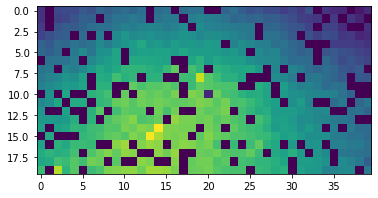

In [64]:
zCoords = preds[20].reshape(20, 40)
plt.imshow(zCoords)

In [65]:
import rasterio
from rasterio.transform import Affine
transform = Affine.translation(xCoords[0] - rasterRes/2, yCoords[0] - rasterRes/2) * Affine.scale(rasterRes, rasterRes)
transform
Affine(0.0, 2.0, 623621.3579761666,
       2.0, 0.0, 8359156.448053772)
#get crs as wkt
from rasterio.crs import CRS
rasterCrs = CRS.from_epsg(32718)
rasterCrs.data
{'init': 'epsg:32718'}
#definition, register and close of interpolated raster
triInterpRaster = rasterio.open('./rst/triangleInterpolation_cop_preds.tif',
                                'w',
                                driver='GTiff',
                                height=zCoords.shape[0],
                                width=zCoords.shape[1],
                                count=1,
                                dtype=zCoords.dtype,
                                #crs='+proj=latlong',
                                crs={'init': 'epsg:32718'},
                                transform=transform,
                                )
triInterpRaster.write(zCoords,1)
triInterpRaster.close()

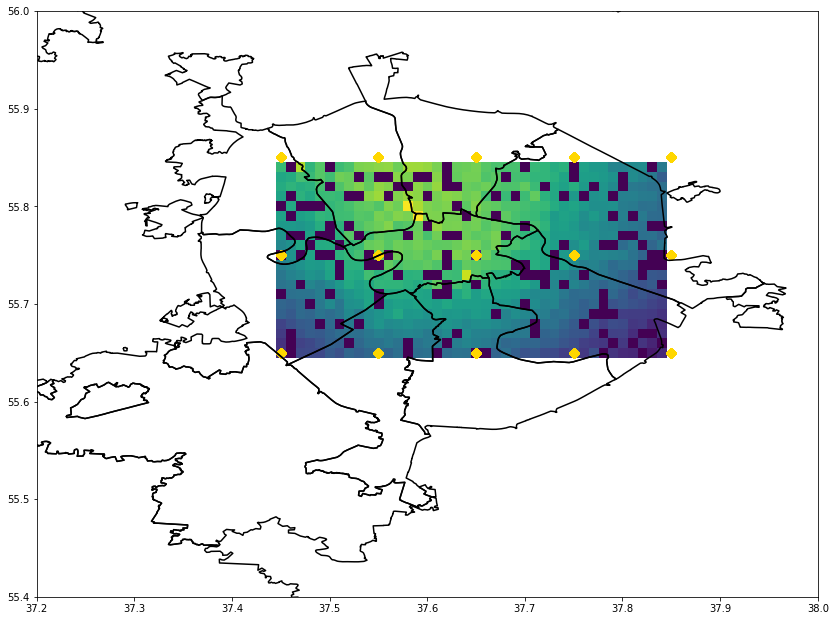

In [66]:
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(14,26))
ax.set_xlim(37.2,38.0)
ax.set_ylim(55.4,56.0)
#ax.set_ylim(8359400,8359800)
src = rasterio.open("./rst/triangleInterpolation_cop_preds.tif")
ao.boundary.plot(ax=ax, color='black', edgecolor='black', aspect=2.25)

points3d.plot(ax=ax, marker='D',markersize=50, color='gold', aspect=2.25)

show(src)
#set_size(10,120,ax=ax)
plt.show()

In [67]:
datetime(2020, 9, 21, 1, 0) + timedelta(hours=66)

datetime.datetime(2020, 9, 23, 19, 0)